# Precison Recall Curve Calculation for Retina
This file is contains the code for calculating the precision recall curve for the RetinaFace model.

In [6]:
import os
import numpy as np
from collections import defaultdict
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt


In [ ]:
def read_annotations(txt_path):

    annotations = []
    if os.path.exists(txt_path):
        with open(txt_path, 'r') as f:
            for line in f.readlines():
                parts = list(map(float, line.strip().split()))
                if len(parts) >= 6:
                    annotations.append({
                        'class': int(parts[0]),
                        'bbox': parts[1:5],  # x_center, y_center, w, h
                        'confidence': parts[5]
                    })
    return annotations

def calculate_iou(box1, box2):

    def to_corners(box):
        x_center, y_center, w, h = box
        x1 = x_center - w/2
        y1 = y_center - h/2
        x2 = x_center + w/2
        y2 = y_center + h/2
        return [x1, y1, x2, y2]
    
    box1 = to_corners(box1)
    box2 = to_corners(box2)
    
    xi1 = max(box1[0], box2[0])
    yi1 = max(box1[1], box2[1])
    xi2 = min(box1[2], box2[2])
    yi2 = min(box1[3], box2[3])
    
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    box1_area = (box1[2]-box1[0])*(box1[3]-box1[1])
    box2_area = (box2[2]-box2[0])*(box2[3]-box2[1])
    
    return inter_area / (box1_area + box2_area - inter_area + 1e-6)

def evaluate_detection(gt_folder, pred_folder, iou_thresh=0.5):
    
    # obtain all predictions and ground truth
    all_preds = []
    gt_db = defaultdict(list)
    total_gts = 0

    # Read all ground truths
    for gt_file in os.listdir(gt_folder):
        if not gt_file.endswith(".txt"): continue
        base_name = os.path.splitext(gt_file)[0]
        gt_path = os.path.join(gt_folder, gt_file)
        gts = read_annotations(gt_path)
        gt_db[base_name] = gts
        total_gts += len(gts)

    # Read all predictions and store with image ID
    for pred_file in os.listdir(pred_folder):
        if not pred_file.endswith(".txt"): continue
        base_name = os.path.splitext(pred_file)[0]
        pred_path = os.path.join(pred_folder, pred_file)
        preds = read_annotations(pred_path)
        
        for pred in preds:
            all_preds.append({
                'image_id': base_name,
                'confidence': pred['confidence'],
                'bbox': pred['bbox']
            })

    # sort by confidence
    all_preds.sort(key=lambda x: -x['confidence'])

    
    matched_gts = defaultdict(set)  # Track matched GT indices per image
    tp_list = []
    fp_list = []
    
    for pred in all_preds:
        image_id = pred['image_id']
        pred_bbox = pred['bbox']
        max_iou = 0.0
        match_idx = -1

        # Find best unmatched GT in this image
        for idx, gt in enumerate(gt_db.get(image_id, [])):
            if idx in matched_gts[image_id]: continue  # Skip already matched
            iou = calculate_iou(pred_bbox, gt['bbox'])
            if iou > max_iou:
                max_iou = iou
                match_idx = idx

        # Determine TP/FP
        if max_iou >= iou_thresh:
            matched_gts[image_id].add(match_idx)
            tp_list.append(1)
            fp_list.append(0)
        else:
            tp_list.append(0)
            fp_list.append(1)

    # calculating final metrics
    tp = np.cumsum(tp_list)
    fp = np.cumsum(fp_list)
    fn = total_gts - tp
    
    precision = tp / (tp + fp + 1e-10)
    recall = tp / (total_gts + 1e-10)
    
    return {
        'precision': precision,
        'recall': recall,
        'AP': average_precision_score(tp_list, [p['confidence'] for p in all_preds]),
        'total_gts': total_gts,
        'total_preds': len(all_preds),
        'tp': tp[-1] if len(tp) > 0 else 0,
        'fp': fp[-1] if len(fp) > 0 else 0,
        'fn': fn[-1] if len(fn) > 0 else total_gts
    }


def plot_metrics(results, iou_thresh=0.5):
    plt.figure(figsize=(12, 5))
    
    # Precision-Recall Curve
    plt.subplot(121)
    plt.plot(results['recall'], results['precision'], label=f'AP={results["AP"]:.3f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve @ IoU={iou_thresh}')
    plt.grid(True)
    plt.legend()

    # Metrics Summary
    plt.subplot(122)
    metrics = [
        ('True Positives', results['tp']),
        ('False Positives', results['fp']),
        ('False Negatives', results['fn']),
        ('Total GT', results['total_gts']),
        ('Total Pred', results['total_preds'])
    ]
    plt.barh([m[0] for m in metrics], [m[1] for m in metrics])
    plt.title('Detection Breakdown')
    plt.tight_layout()
    plt.show()


Average Precision: 0.9407
Recall: 0.2399
Precision: 0.7940
False Negatives: 5484


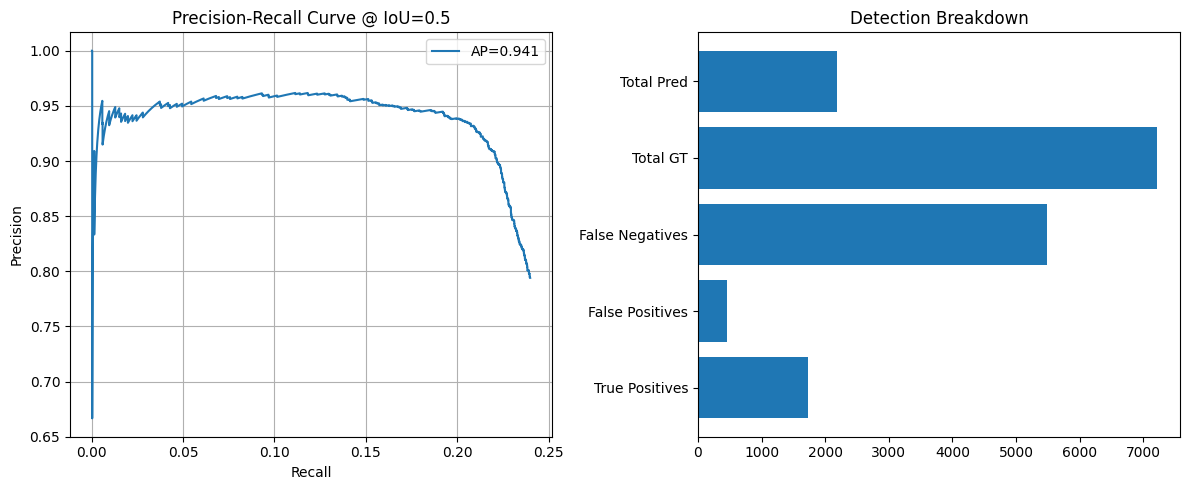

In [ ]:
# Folder A (ground truth annotations) with Folder B (model predictions)
# Run evaluation
# groundTruth = "../ssic_image-corpus/data_phase-4_consensus/face/label_face_only_actual_yolo"

groundTruth = "../ssic_image-corpus/data_phase-4_consensus/face/label_face_only_actual_yolo"

modelPrediction = "../ssic_image-corpus/data_phase-4_consensus/face/retinaface_output_toyolo"


results = evaluate_detection(groundTruth, modelPrediction, iou_thresh=0.5)
print(f"Average Precision: {results['AP']:.4f}")
print(f"Recall: {results['recall'][-1]:.4f}")
print(f"Precision: {results['precision'][-1]:.4f}")
print(f"False Negatives: {results['fn']}")
plot_metrics(results)

IoU=0.50: AP=0.9407 | TP=1731, FP=449, FN=5484
IoU=0.55: AP=0.9153 | TP=1690, FP=490, FN=5525
IoU=0.60: AP=0.8823 | TP=1632, FP=548, FN=5583
IoU=0.65: AP=0.8129 | TP=1516, FP=664, FN=5699
IoU=0.70: AP=0.7394 | TP=1357, FP=823, FN=5858
IoU=0.75: AP=0.6080 | TP=1113, FP=1067, FN=6102
IoU=0.80: AP=0.4495 | TP=816, FP=1364, FN=6399
IoU=0.85: AP=0.2613 | TP=478, FP=1702, FN=6737
IoU=0.90: AP=0.0866 | TP=162, FP=2018, FN=7053
IoU=0.95: AP=0.0073 | TP=10, FP=2170, FN=7205

COCO-style mAP@[0.5:0.95]: 0.5703


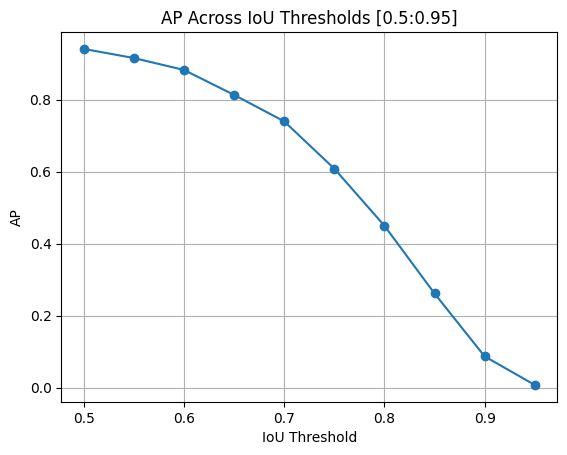

In [ ]:
import numpy as np
from sklearn.metrics import average_precision_score

# Calculate COCO-style mAP across IoU thresholds [0.5:0.95]
def calculate_coco_ap(gt_folder, pred_folder):

    aps = []
    thresholds = np.arange(0.5, 1.0, 0.05)
    
    for thresh in thresholds:
        # Use the comprehensive evaluation function
        results = evaluate_detection(gt_folder, pred_folder, iou_thresh=thresh)
        
        # Calculate AP for this threshold
        ap = results['AP']
        aps.append(ap)
        
        # Print diagnostics
        print(f"IoU={thresh:.2f}: AP={ap:.4f} | "
              f"TP={results['tp']}, FP={results['fp']}, FN={results['fn']}")

    # Calculate mean AP (mAP)
    map_value = np.mean(aps)
    print(f"\nCOCO-style mAP@[0.5:0.95]: {map_value:.4f}")
    
    return aps, map_value

# Example usage
groundTruth = "../ssic_image-corpus/data_phase-4_consensus/face/label_face_only_actual_yolo"

modelPrediction = "../ssic_image-corpus/data_phase-4_consensus/face/retinaface_output_toyolo"
aps, map_value = calculate_coco_ap(groundTruth, modelPrediction)

# Plot AP across thresholds
import matplotlib.pyplot as plt
plt.plot(np.arange(0.5, 1.0, 0.05), aps, marker='o')
plt.xlabel("IoU Threshold")
plt.ylabel("AP")
plt.title("AP Across IoU Thresholds [0.5:0.95]")
plt.grid(True)
plt.show()